In [1]:
import sys
sys.path.append("..")
from VAE.vae import *

In [150]:
config_space = ConfigurationSpace(
                {'input_dropout': 0.1, 'intermediate_activation': "relu", 'intermediate_dimension': 30,
                'intermediate_layers': 3, 'latent_dimension': 3, 'learning_rate': 0.0001,
                'original_dim': 825000, 'solver': 'nadam'}
            )
config = config_space.get_default_configuration()

In [166]:
from keras import initializers, regularizers , constraints

class DenseTied(keras.layers.Layer):
  def __init__(self, tie, activation=None, **kwargs):
      self.tie = tie
      self.activation = keras.activations.get(activation)
      super().__init__(**kwargs)
  def build(self, batch_input_shape):
      self.biases = self.add_weight(name="bias", initializer="zeros", shape=[ops.shape(self.tie.input)[-1]])
      self.kernel = ops.transpose(self.tie.kernel)
      self.non_trainable_weights.append(self.kernel)
      self.built = True
      super().build(batch_input_shape)
  def call(self, inputs):
      z = ops.matmul(inputs,self.kernel)
      return self.activation(z + self.biases)

In [167]:
@keras.saving.register_keras_serializable(package="FIA_VAE")
class FIA_VAE(Model):
    """
    A variational autoencoder for flow injection analysis
    """
    def __init__(self, config:Union[Configuration, dict]):
        super().__init__()
        self.config             = config
        intermediate_dims       = [i for i in range(config["intermediate_layers"]) 
                                    if config["intermediate_dimension"] // 2**i > config["latent_dimension"]]
        activation_function     = self.get_activation_function( config["intermediate_activation"] )

        # Encoder (with sucessive halfing of intermediate dimension)
        self.dropout            = Dropout( config["input_dropout"] , name="dropout")        
        self.intermediate_enc   = Sequential ( [ Input(shape=(config["original_dim"],), name='encoder_input') ] +
                                               [ Dense( config["intermediate_dimension"] // 2**i,
                                                        activation=activation_function ) 
                                                for i in intermediate_dims] +
                                               [ Dense( config["latent_dimension"] ) ] , name="encoder_intermediate")

        self.mu_encoder         = Dense( config["latent_dimension"], name='latent_mu' )
        self.sigma_encoder      = Dense( config["latent_dimension"], name='latent_sigma' )
        self.z_encoder          = self.Sampling(name="latent_reparametrization") 

        # Decoder
        self.decoder            = Sequential( [ Input(shape=(config["latent_dimension"], ), name='decoder_input') ] +
                                              [ DenseTied( tie=self.intermediate_enc.get_layer(index=i+1),
                                                           activation=activation_function )
                                               for i in reversed(intermediate_dims) ] +
                                              [ Dense(config["original_dim"], activation="relu") ] , name="Decoder")

        # Define optimizer
        self.optimizer          = self.get_solver( config["solver"] )( config["learning_rate"] )

        # Compile VAE
        self.compile(optimizer=self.optimizer)

        # Loss trackers
        self.reconstruction_loss    = metrics.Mean(name="reconstruction_loss")
        self.kl_loss                = metrics.Mean(name="kl_loss")
        self.loss_tracker           = metrics.Mean(name="loss")

    
    def get_activation_function(self, activation_function:str):
        """
        Convert an activation function string into a keras function

        Args:
            activation_function (str): Activation function in string representation
        Returns:
            Activation function as keras.activations or keras.layers
        """
        activation_functions = {"relu": activations.relu, "leakyrelu" :layers.LeakyReLU(), "selu": activations.selu, "tanh": activations.tanh}
        return activation_functions[activation_function]

    
    def get_solver(self, solver:str):
        """
        Convert an solver string into a keras function

        Args:
            solver (str): Solver in string representation 
        Returns:
            solver as a keras.optimizers class
        """
        solvers = {"adam": optimizers.Adam, "nadam": optimizers.Nadam, "adamw": optimizers.AdamW}
        return solvers[solver]
    
    class Sampling(layers.Layer):
        """
        Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
        """
        def call(self, inputs):
            z_mean, z_log_var = inputs
            z_mean_shape = ops.shape(z_mean)
            batch   = z_mean_shape[0]
            dim     = z_mean_shape[1]
            epsilon = keras.random.normal(shape=(batch,dim))
            return ops.multiply(ops.add(z_mean, ops.exp(0.5 * z_log_var)), epsilon)

    def kl_reconstruction_loss(self, y_true, y_pred):
        """
        Loss function for Kullback-Leibler + Reconstruction loss

        Args:
            true: True values
            pred: Predicted values
        Returns:
            Loss = Kullback-Leibler + Reconstruction loss
        """
        reconstruction_loss = losses.mean_absolute_error(y_true, y_pred)
        kl_loss = -0.5 * ops.sum( 1.0 + self.sigma - ops.square(self.mu) - ops.exp(self.sigma) )
        loss = reconstruction_loss + kl_loss
        
        return {"reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss, "loss": loss}

    @property
    def metrics(self):
        return [self.loss_tracker, self.reconstruction_loss, self.kl_loss]
    
    def get_config(self):
        return {"config": dict(self.config)}

    def call(self, data, training=False):
        x = self.dropout(data, training=training)
        return self.decode(self.encode(x))

    def encode(self, data):
        x = self.intermediate_enc(data)
        self.mu = self.mu_encoder(x)
        self.sigma = self.sigma_encoder(x)
        self.z = self.z_encoder( [self.mu, self.sigma] )
        return self.z
    
    def encode_mu(self, data):
        x = self.intermediate_enc(data)
        return self.mu(x)
    
    def decode(self, x):
        return self.decoder(x)

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute our own loss
            loss = self.kl_reconstruction_loss(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.reconstruction_loss.update_state( loss["reconstruction_loss"] )
        self.kl_loss.update_state( loss["kl_loss"] )
        self.loss_tracker.update_state( loss["loss"] )
        return loss
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        loss = self.kl_reconstruction_loss(y, y_pred)
        self.reconstruction_loss.update_state( loss["reconstruction_loss"] )
        self.kl_loss.update_state( loss["kl_loss"] )
        self.loss_tracker.update_state( loss["loss"] )
        return loss

In [ ]:
model = FIA_VAE(config)

In [168]:
model.intermediate_enc.summary()

Model: "encoder_intermediate"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_209 (Dense)               │ (None, 30)             │    24,750,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 7)              │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 3)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,750,631 (94.42 MB)

 Trainable params: 24,750,631 (94.42 MB)

 Non-trainable params: 0 (0.00 B)

In [165]:
model.summary()

Model: "fia_vae_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_intermediate            │ ?                      │    24,750,631 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_mu (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_sigma (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_reparametrization        │ ?                      │   0 (unbuilt) │
│ (Sampling)                      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ ?                      │    25,575,653 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,325,683 (191.98 MB)

 Trainable params: 50,325,683 (191.98 MB)

 Non-trainable params: 0 (0.00 B)

## Saving

In [169]:
keras.saving.save_model(model, "../../runs/VAE/training/test.keras")

/mnt/lustre/groups/link/linca945/.conda/envs/FIA_VAE/lib/python3.11/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


In [170]:
model.save_weights("../../runs/VAE/training/test.weights.h5")

## Loading

In [171]:
model2 = keras.saving.load_model("../../runs/VAE/training/test.keras")

In [172]:
model2.load_weights("../../runs/VAE/training/test.weights.h5")

## Testing

In [173]:
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "../../runs/FIA/Com8_grown_together/oms"))
data = read_data(data_dir, verbosity=0)

In [174]:
X = np.random.normal(0.0, 1.0, size=(5, 825000))

In [175]:
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="../../runs/VAE/training/test_{epoch}.keras",
                                                       save_best_only=True, monitor="val_loss",
                                                       verbose=1 )]

In [177]:
model2.fit(data, data, validation_split=0.2, batch_size=2, epochs=10, callbacks=callbacks)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - kl_loss: 1.0046e-05 - loss: 7.5954e-04 - reconstruction_loss: 7.4949e-04
Epoch 1: val_loss improved from 0.84002 to 0.00037, saving model to ../../runs/VAE/training/test_1.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 875ms/step - kl_loss: 1.0046e-05 - loss: 7.5954e-04 - reconstruction_loss: 7.4949e-04 - val_kl_loss: 1.2036e-05 - val_loss: 3.7028e-04 - val_reconstruction_loss: 3.5824e-04
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - kl_loss: 1.2471e-05 - loss: 3.0458e-04 - reconstruction_loss: 2.9211e-04
Epoch 2: val_loss improved from 0.00037 to 0.00005, saving model to ../../runs/VAE/training/test_2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 378ms/step - kl_loss: 1.2471e-05 - loss: 3.0458e-04 - reconstruction_loss: 2.9211e-04 - val_kl_loss: 1.2636e-05 - val_loss: 5.2885e-05 - val_reconstruction_loss: 4.0249e-05
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - kl_loss: 1.2674e-05 - loss: 1.0618e-04 - reconstruction_loss: 9.3509e-05
E

In [17]:
loss, kl_loss, recon_loss = model2.evaluate(data, data, batch_size=68)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - kl_loss: nan - loss: nan - reconstruction_loss: nan


In [178]:
prediction = pd.DataFrame(model2.predict(data))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [187]:
plot_df = pd.DataFrame(prediction.loc[1].values, index=data.columns, columns=["inty"]).reset_index()
plot_df_2 = pd.DataFrame(data.iloc[1].values, index=data.columns, columns=["inty"]).reset_index()

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

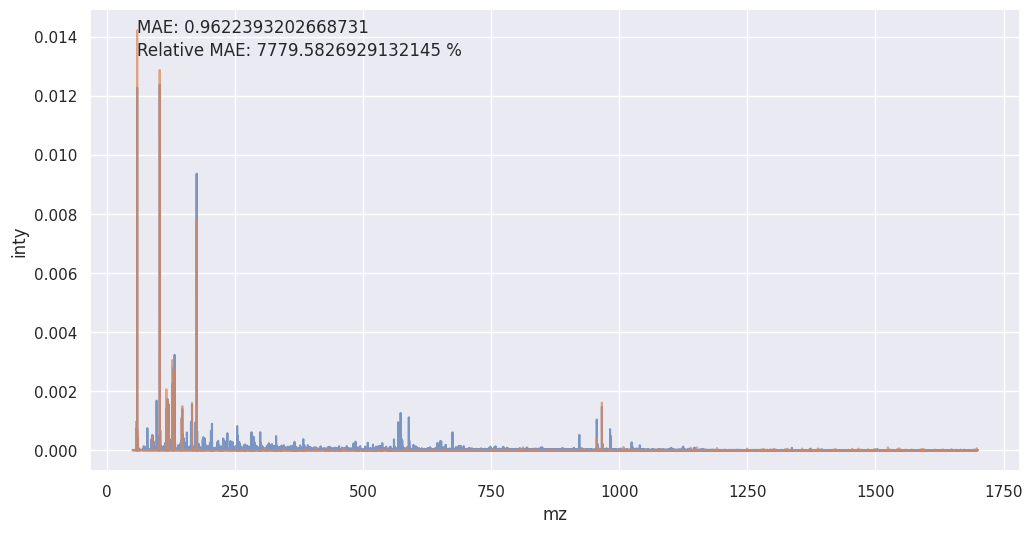

In [190]:
mae = np.mean(np.sum( np.abs((plot_df_2["inty"] - plot_df["inty"])) ))
rel_mae = mae / np.max(plot_df_2["inty"])

sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty", alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
plt.annotate(f"MAE: {mae}", xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate(f"Relative MAE: {rel_mae *100} %", xy=(0.05, 0.90), xycoords='axes fraction')
plt.show()